add a rln column for shortwave and longwave
create a forcing dataset where the last 
#get all dimensions labeled
make a figure for error
write a function that computes the error, make a dict that is gbme for each of parameterized models
#coordinate labels for experiments and errors in terms of longwave and shortwave
#identify big error
#take a look at rsd at the top of atmosphere
#list of urls in text file of https download links

In [2]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

In [3]:
def compute_global_mean(ds):
    wts = ds.profile_weight/ds.profile_weight.sum()
    return(ds.weighted(wts).mean(["site"]))

In [4]:
#copy directory here
os.chdir('/Users/emmalayton/Desktop/senior_thesis/RFMIP-IRF_intake_catalogue')

In [5]:
from intake import open_catalog
cat = open_catalog(os.getcwd() + '/main.yml')

In [6]:
extrainfo = xr.open_dataset(os.getcwd() + '/multiple_input4MIPs_radiation_RFMIP_UColorado-RFMIP-1-2_none.nc').to_dataframe()

In [7]:
extrainfo['expt_label'].unique()

array(['Present day (PD)',
       'Pre-industrial (PI) greenhouse gas concentrations', '4xCO2',
       '"future"', '0.5xCO2', '2xCO2', '3xCO2', '8xCO2', 'PI CO2',
       'PI CH4', 'PI N2O', 'PI O3', 'PI HCs', '+4K', '+4K, const. RH',
       'PI all', '"future" all', 'LGM'], dtype=object)

In [8]:
list(cat.benchmark)

['LBLRTM', '_4AOP', 'ARTS', 'HadGEM3']

In [9]:
xr.concat([compute_global_mean(cat.parameterized.RRTMG.p1f1[f].to_dask()) for f in ["rlu", "rld", "rsu", "rsd"]], 
          dim="field", data_vars = "different")

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:         (expt: 18, level: 61)
Dimensions without coordinates: expt, level
Data variables:
    rld             (expt, level) float32 0.0 0.2315 0.4441 ... 310.5 311.9
    rsu             (expt, level) float32 30.24 30.26 30.3 ... 48.78 48.78 48.79
    rsd             (expt, level) float32 247.1 247.3 247.6 ... 335.1 335.2
    plev            (level) float32 0.01 20.0 38.43 ... 9.839e+04 9.862e+04
    rlu             (expt, level) float32 264.4 264.5 264.5 ... 395.6 397.8
    profile_weight  float64 0.01053

In [10]:
benchmark = xr.concat([compute_global_mean(cat.benchmark.LBLRTM.p1f1[f].to_dask()) 
                               for f in ["rlu", "rld", "rsu", "rsd"]], 
                               dim="field", data_vars = "different")

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [11]:
gbms = {}
for m in list(cat.parameterized):
    if "MIROC6" not in m:
        print("Trying model ", m)
        for r in list(cat.parameterized[m]):
            print(" Realization ", r)
            gbms[f'{m}_{r}'] = xr.concat([compute_global_mean(cat.parameterized[m][r][f].to_dask()) 
                                    for f in ["rlu","rld","rsu","rsd"]], 
                                    dim="field", data_vars = "different")
        
gbms = {k: gbms[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in gbms.keys()}

Trying model  CanESM5
 Realization  p2f2
Trying model  GISS_E2
 Realization  p1f1
Trying model  GISS_E3
 Realization  p1f1
Trying model  HadGEM3
 Realization  p1f2


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

 Realization  p1f3


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Trying model  GFDL
 Realization  p1f2
Trying model  RRTMG
 Realization  p1f1
Trying model  RTE_RRTMGP
 Realization  p1f1


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [41]:
gbms["CanESM5_p2f2"].expt

<xarray.DataArray 'expt' (expt: 18)>
array(['Present day (PD)', 'Pre-industrial (PI) greenhouse gas concentrations',
       '4xCO2', '"future"', '0.5xCO2', '2xCO2', '3xCO2', '8xCO2', 'PI CO2',
       'PI CH4', 'PI N2O', 'PI O3', 'PI HCs', '+4K', '+4K, const. RH',
       'PI all', '"future" all', 'LGM'], dtype=object)
Coordinates:
  * expt     (expt) object 'Present day (PD)' ... 'LGM'

In [102]:
gbms["GFDL_p1f2"]

<xarray.Dataset>
Dimensions:         (expt: 18, level: 61)
Coordinates:
  * expt            (expt) object 'Present day (PD)' ... 'LGM'
Dimensions without coordinates: level
Data variables:
    rld             (expt, level) float32 0.0 nan nan nan ... nan nan nan 316.2
    rsu             (expt, level) float32 47.21 47.2 47.19 ... 30.23 30.19 30.16
    rsd             (expt, level) float32 335.2 335.1 334.9 ... 246.6 246.3
    plev            (level) float32 0.01 20.0 38.43 ... 9.839e+04 9.862e+04
    profile_weight  float64 0.01053
    rlu             (expt, level) float32 261.2 nan nan nan ... nan nan 399.8
    rln             (expt, level) float32 -261.2 nan nan nan ... nan nan -83.62
    rsn             (expt, level) float32 288.0 287.9 287.7 ... 216.4 216.2

In [103]:
#calculate benchmark lw and sw flux
benchmark = benchmark.assign(rln=benchmark.data_vars['rld']-benchmark.data_vars['rlu'])
benchmark = benchmark.assign(rsn=benchmark.data_vars['rsd']-benchmark.data_vars['rsu'])
#calculate parameterized lw and sw flux
gbms = {k: gbms[k].assign(rln=gbms[k].data_vars['rld']-gbms[k].data_vars['rlu']) for k in gbms.keys()}
gbms = {k: gbms[k].assign(rsn=gbms[k].data_vars['rsd']-gbms[k].data_vars['rsu']) for k in gbms.keys()}


In [106]:
gbms

{'CanESM5_p2f2': <xarray.Dataset>
 Dimensions:         (expt: 18, level: 61)
 Coordinates:
   * expt            (expt) object 'Present day (PD)' ... 'LGM'
 Dimensions without coordinates: level
 Data variables:
     rld             (expt, level) float32 0.0 0.2265 0.4303 ... 309.9 311.5
     rsu             (expt, level) float32 47.7 47.7 47.7 ... 30.43 30.39 30.37
     rsd             (expt, level) float32 335.2 335.1 334.9 ... 248.8 248.6
     plev            (level) float32 0.01 20.0 38.43 ... 9.839e+04 9.862e+04
     rlu             (expt, level) float32 264.6 264.7 264.7 ... 395.8 397.8
     profile_weight  float64 0.01053
     rln             (expt, level) float32 -264.6 -264.4 -264.3 ... -85.93 -86.34
     rsn             (expt, level) float32 287.5 287.4 287.2 ... 218.4 218.3,
 'GISS_E2_p1f1': <xarray.Dataset>
 Dimensions:         (expt: 18, level: 61)
 Coordinates:
   * expt            (expt) object 'Present day (PD)' ... 'LGM'
 Dimensions without coordinates: level
 Data vari

In [104]:
gbmforcing = gbms.copy()
for m in list(gbms.keys()):
    gbmforcing[m] = gbmforcing[m] - gbmforcing[m].isel(expt=0)

In [105]:
gbmforcing["GFDL_p1f2"]

<xarray.Dataset>
Dimensions:         (expt: 18, level: 61)
Coordinates:
  * expt            (expt) object 'Present day (PD)' ... 'LGM'
Dimensions without coordinates: level
Data variables:
    rld             (expt, level) float32 0.0 nan nan nan ... nan nan nan -3.646
    rsu             (expt, level) float32 0.0 0.0 0.0 ... 0.07961 0.07959
    rsd             (expt, level) float32 0.0 0.0 0.0 ... 0.7245 0.7243 0.7241
    plev            (level) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    profile_weight  float64 0.0
    rlu             (expt, level) float32 0.0 nan nan nan ... nan nan nan 0.0
    rln             (expt, level) float32 0.0 nan nan nan ... nan nan nan -3.646
    rsn             (expt, level) float32 0.0 0.0 0.0 ... 0.6449 0.6447 0.6445

In [17]:
gbmforcing_b = benchmark.copy()
gbmforcing_b = gbmforcing_b - gbmforcing_b.isel(expt=0)

In [58]:
gbme = {k: (gbmforcing[k]-gbmforcing_b) for k in gbmforcing.keys()}

In [98]:
gbme["GFDL_p1f2"]

<xarray.Dataset>
Dimensions:         (expt: 18, level: 61)
Coordinates:
  * expt            (expt) object 'Present day (PD)' ... 'LGM'
Dimensions without coordinates: level
Data variables:
    rld             (expt, level) float32 0.0 nan nan nan ... nan nan -0.1264
    rsu             (expt, level) float32 0.0 0.0 0.0 ... -0.02977 -0.02976
    rsd             (expt, level) float32 0.0 0.0 0.0 ... -0.1875 -0.1873
    plev            (level) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    profile_weight  float64 0.0
    rlu             (expt, level) float32 0.0 nan nan nan ... nan nan 0.07034
    rln             (expt, level) float32 0.0 nan nan nan ... nan nan -0.1967
    rsn             (expt, level) float32 0.0 0.0 0.0 ... -0.1577 -0.1576

In [19]:
gbme["CanESM5_p2f2"].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2'])

<xarray.Dataset>
Dimensions:         (expt: 6, level: 2)
Coordinates:
  * expt            (expt) object '4xCO2' '0.5xCO2' '2xCO2' ... '8xCO2' 'PI CO2'
Dimensions without coordinates: level
Data variables:
    rld             (expt, level) float32 0.0 -0.1603 0.0 ... -0.2448 0.0 0.1321
    rsu             (expt, level) float32 -0.07361 -0.02029 ... -0.006342
    rsd             (expt, level) float32 0.0 -0.1644 0.0 ... 0.0 -0.006836
    plev            (level) float32 0.0 0.0
    rlu             (expt, level) float32 0.183 -0.003265 ... -0.08881 0.002625
    profile_weight  float64 0.0
    rln             (expt, level) float32 -0.183 -0.157 ... 0.08881 0.1295
    rsn             (expt, level) float32 0.07364 -0.1441 ... -0.0004883

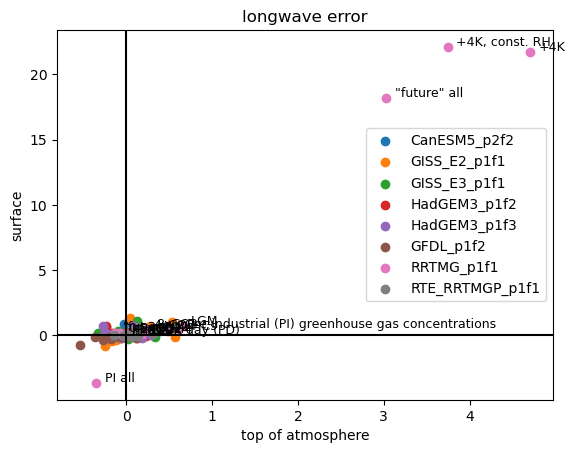

In [64]:
fig, ax = plt.subplots()
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rln"][:,0],gbme[m].data_vars["rln"][:,60])
    if "RRTMG_p1f1" in m:
        for i in range(len(gbme[m].expt)):
            plt.text(gbme[m].data_vars["rln"][i,0]+0.1,gbme[m].data_vars["rln"][i,60]+0.1, gbme[m].expt[i].values, fontsize=9) 
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("longwave error")
plt.show()

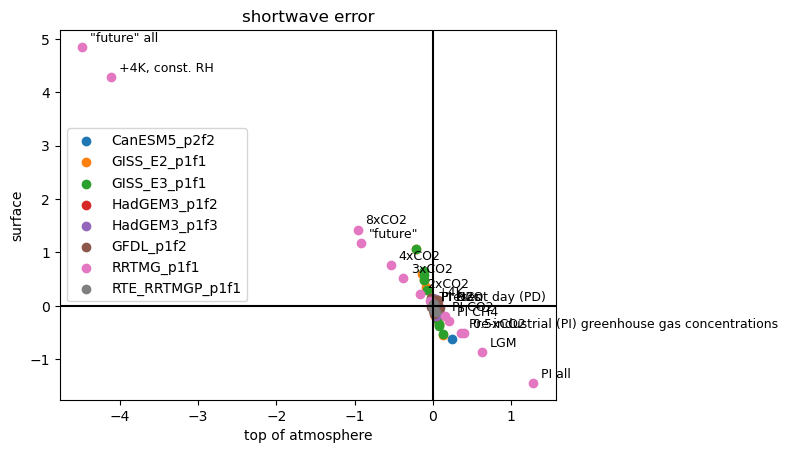

In [62]:
fig1, ax1 = plt.subplots()
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rsn"][:,0],gbme[m].data_vars["rsn"][:,60])
    if "RRTMG_p1f1" in m:
        for i in range(len(gbme[m].expt)):
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.1,gbme[m].data_vars["rsn"][i,60]+0.1, gbme[m].expt[i].values, fontsize=9) 

#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("shortwave error")
plt.show()

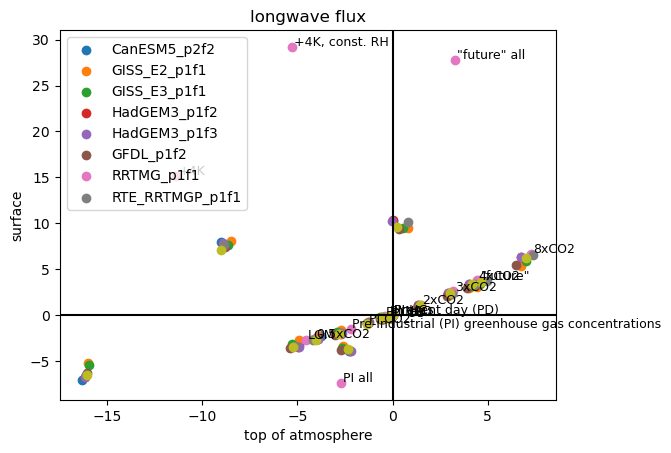

In [63]:
fig, ax = plt.subplots()
for m in list(gbmforcing.keys()):
    plt.scatter(gbmforcing[m]["rln"][:,0],gbmforcing[m]["rln"][:,60])
    if "RRTMG_p1f1" in m:
        for i in range(len(gbme[m].expt)):
            plt.text(gbmforcing[m].data_vars["rln"][i,0]+0.1,gbmforcing[m].data_vars["rln"][i,60]+0.1, gbmforcing[m].expt[i].values, fontsize=9) 
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.scatter(gbmforcing_b["rln"][:,0],gbmforcing_b["rln"][:,60])

plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbmforcing.keys()))
plt.title("longwave flux")
plt.show()

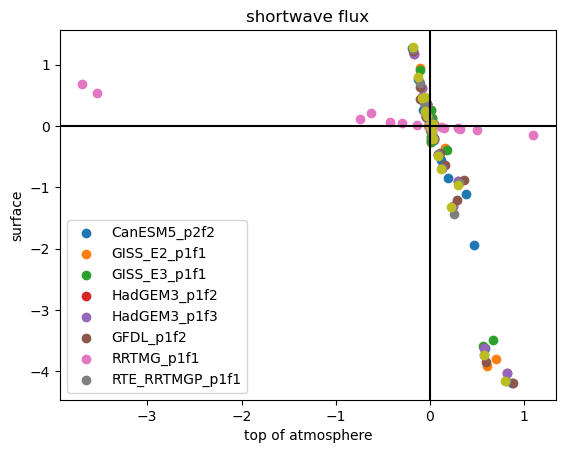

In [61]:
fig, ax = plt.subplots()
for m in list(gbmforcing.keys()):
    plt.scatter(gbmforcing[m]["rsn"][:,0],gbmforcing[m]["rsn"][:,60])
plt.scatter(gbmforcing_b["rsn"][:,0],gbmforcing_b["rsn"][:,60])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbmforcing.keys()))
plt.title("shortwave flux")
plt.show()

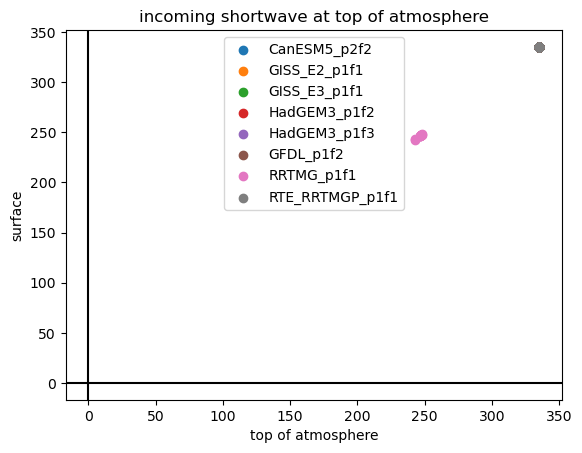

In [35]:
fig, ax = plt.subplots()
for m in list(gbms.keys()):
    plt.scatter(gbms[m].data_vars["rsd"][:,0],gbms[m].data_vars["rsd"][:,0])
'''
    if "RRTMG_p1f1" in m:
        for i in range(len(gbme[m].expt)):
            plt.text(gbme[m].data_vars["rln"][i,0]+0.1,gbme[m].data_vars["rln"][i,1]+0.1, gbme[m].expt[i].values, fontsize=9) 
'''
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("incoming shortwave at top of atmosphere")
plt.show()

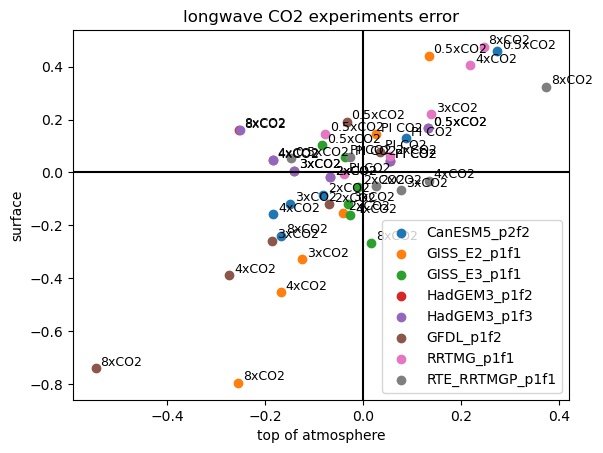

In [136]:
fig, ax = plt.subplots()
selected_experiments = ['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']

for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']),gbme[m].data_vars["rln"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rln"][i,0]+0.01,gbme[m].data_vars["rln"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("longwave CO2 experiments error")
plt.show()

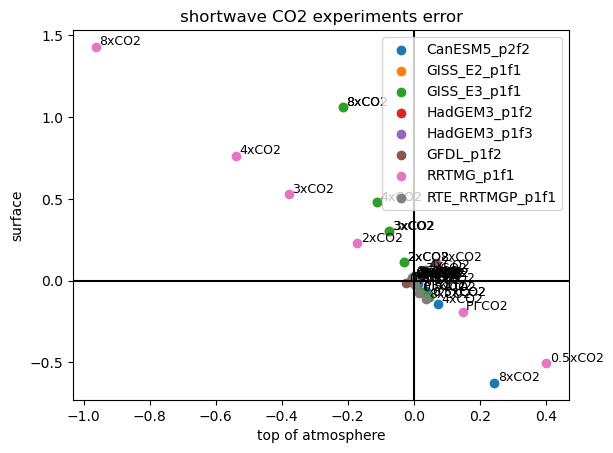

In [134]:
fig, ax = plt.subplots()
selected_experiments = ['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']),gbme[m].data_vars["rsn"][:,60].sel(expt=['4xCO2','0.5xCO2','2xCO2','3xCO2','8xCO2', 'PI CO2']))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.01,gbme[m].data_vars["rsn"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)
    #plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("shortwave CO2 experiments error")
plt.show()

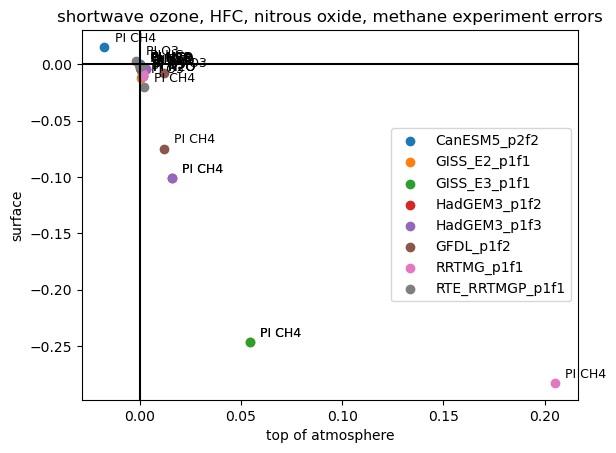

In [132]:
fig, ax = plt.subplots()
selected_experiments = [ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']),gbme[m].data_vars["rsn"][:,60].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.005,gbme[m].data_vars["rsn"][i,60]+0.005, gbme[m].expt[i].values, fontsize=9)
    #plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("shortwave ozone, HFC, nitrous oxide, methane experiment errors")
plt.show()

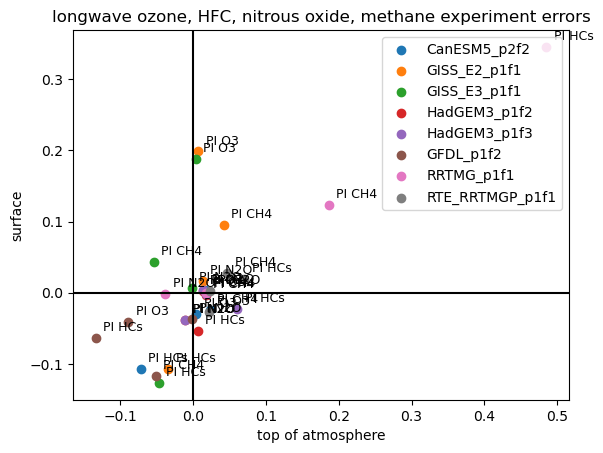

In [125]:
fig, ax = plt.subplots()
selected_experiments = [ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']),gbme[m].data_vars["rln"][:,60].sel(expt=[ 'PI CH4', 'PI N2O', 'PI O3', 'PI HCs']))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rln"][i,0]+0.01,gbme[m].data_vars["rln"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("longwave ozone, HFC, nitrous oxide, methane experiment errors")
plt.show()

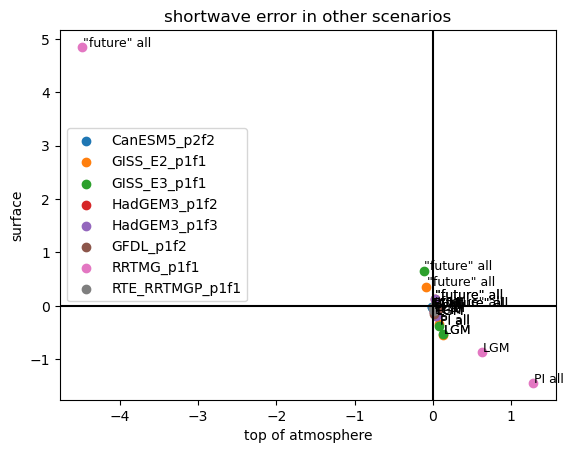

In [129]:
fig, ax = plt.subplots()
selected_experiments = [ 'PI all', '"future" all', 'LGM']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=[ 'PI all', '"future" all', 'LGM']),gbme[m].data_vars["rsn"][:,60].sel(expt=[ 'PI all', '"future" all', 'LGM']))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.01,gbme[m].data_vars["rsn"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("shortwave error in other scenarios")
plt.show()

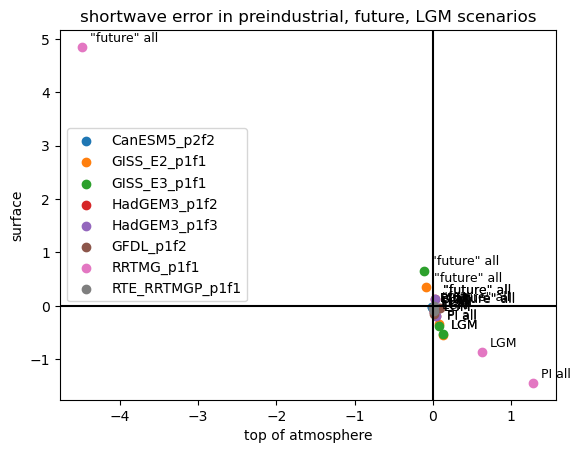

In [117]:
fig, ax = plt.subplots()
selected_experiments = [ 'PI all', '"future" all', 'LGM']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=[ 'PI all', '"future" all', 'LGM']),gbme[m].data_vars["rsn"][:,60].sel(expt=[ 'PI all', '"future" all', 'LGM']))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.1,gbme[m].data_vars["rsn"][i,60]+0.1, gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("shortwave error in preindustrial, future, LGM scenarios")
plt.show()

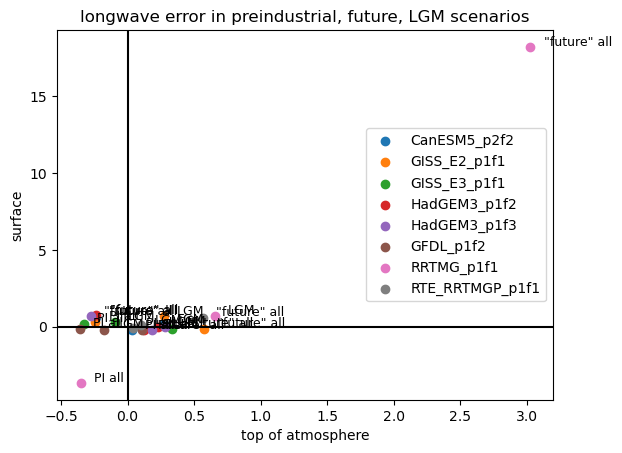

In [122]:
fig, ax = plt.subplots()
selected_experiments = [ 'PI all', '"future" all', 'LGM']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=[ 'PI all', '"future" all', 'LGM']),gbme[m].data_vars["rln"][:,60].sel(expt=[ 'PI all', '"future" all', 'LGM']))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rln"][i,0]+0.1,gbme[m].data_vars["rln"][i,60]+0.1, gbme[m].expt[i].values, fontsize=9)
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("longwave error in preindustrial, future, LGM scenarios")
plt.show()

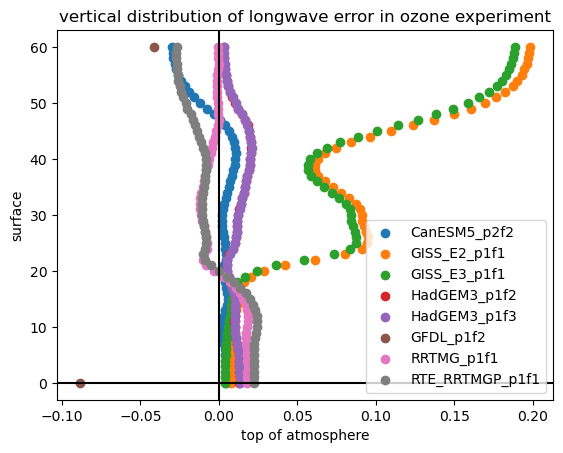

In [91]:
#vertical structure of O3
fig, ax = plt.subplots()
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rln"].sel(expt=[ 'PI O3']),np.arange(61))
plt.xlabel("top of atmosphere")
plt.legend(list(gbme.keys()))
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.title("vertical distribution of longwave error in ozone experiment")
plt.show()

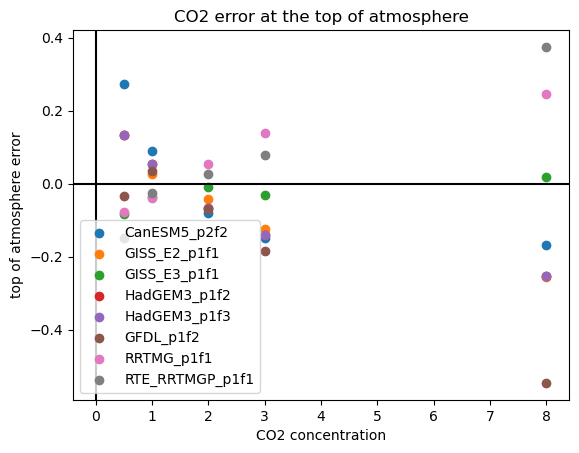

In [116]:
#vertical structure of O3
fig, ax = plt.subplots()
for m in list(gbme.keys()):
    plt.scatter([0.5, 1, 2, 3, 8], gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0))
plt.xlabel("CO2 concentration")
plt.legend(list(gbme.keys()))
plt.ylabel("top of atmosphere error")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.title("CO2 error at the top of atmosphere")
plt.show()